In [5]:
import tensorflow as tf
import tensorflow_datasets as tfds

import numpy as np
import matplotlib.pyplot as plt

def map_image_with_noise(image, label):
  '''Normalizes the images and generates noisy inputs.'''
  image = tf.cast(image, dtype=tf.float32)
  image = image / 255.0
  
  noise_factor = 0.5
  factor = noise_factor * tf.random.normal(shape=image.shape)
  image_noisy = image + factor
  image_noisy = tf.clip_by_value(image_noisy, 0.0, 1.0)
 
  return image_noisy, image

BATCH_SIZE = 128
SHUFFLE_BUFFER_SIZE = 1024

train_dataset = tfds.load('mnist', as_supervised=True, split="train")
train_dataset = train_dataset.map(map_image_with_noise)
train_dataset = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE).repeat()

test_dataset = tfds.load('mnist', as_supervised=True, split="test")
test_dataset = test_dataset.map(map_image_with_noise)
test_dataset = test_dataset.batch(BATCH_SIZE).repeat()


def encoder(inputs):
  '''Defines the encoder with two Conv2D and max pooling layers.'''
  conv_1 = tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same')(inputs)
  max_pool_1 = tf.keras.layers.MaxPooling2D(pool_size=(2,2))(conv_1)

  conv_2 = tf.keras.layers.Conv2D(filters=128, kernel_size=(3,3), activation='relu', padding='same')(max_pool_1)
  max_pool_2 = tf.keras.layers.MaxPooling2D(pool_size=(2,2))(conv_2)

  return max_pool_2

def bottle_neck(inputs):
  '''Defines the bottleneck.'''
  bottle_neck = tf.keras.layers.Conv2D(filters=256, kernel_size=(3,3), activation='relu', padding='same')(inputs)
  encoder_visualization = tf.keras.layers.Conv2D(filters=1, kernel_size=(3,3), activation='sigmoid', padding='same')(bottle_neck)

  return bottle_neck, encoder_visualization

def decoder(inputs):
  '''Defines the decoder path to upsample back to the original image size.'''
  conv_1 = tf.keras.layers.Conv2D(filters=128, kernel_size=(3,3), activation='relu', padding='same')(inputs)
  up_sample_1 = tf.keras.layers.UpSampling2D(size=(2,2))(conv_1)

  conv_2 = tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same')(up_sample_1)
  up_sample_2 = tf.keras.layers.UpSampling2D(size=(2,2))(conv_2)

  conv_3 = tf.keras.layers.Conv2D(filters=1, kernel_size=(3,3), activation='sigmoid', padding='same')(up_sample_2)

  return conv_3

def convolutional_auto_encoder():
  '''Builds the entire autoencoder model.'''
  inputs = tf.keras.layers.Input(shape=(28, 28, 1,))
  encoder_output = encoder(inputs)
  bottleneck_output, encoder_visualization = bottle_neck(encoder_output)
  decoder_output = decoder(bottleneck_output)
  
  model = tf.keras.Model(inputs =inputs, outputs=decoder_output)
  encoder_model = tf.keras.Model(inputs=inputs, outputs=encoder_visualization)
  return model, encoder_model

convolutional_model, convolutional_encoder_model = convolutional_auto_encoder()
convolutional_model.summary()


train_steps = 60000 // BATCH_SIZE
valid_steps = 60000 // BATCH_SIZE

convolutional_model.compile(optimizer=tf.keras.optimizers.Adam(), loss='binary_crossentropy')
conv_model_history = convolutional_model.fit(train_dataset, steps_per_epoch=train_steps, validation_data=test_dataset, validation_steps=valid_steps, epochs=40)

def display_one_row(disp_images, offset, shape=(28, 28)):
  '''Display sample outputs in one row.'''
  for idx, noisy_image in enumerate(disp_images):
    plt.subplot(3, 10, offset + idx + 1)
    plt.xticks([])
    plt.yticks([])
    noisy_image = np.reshape(noisy_image, shape)
    plt.imshow(noisy_image, cmap='gray')


def display_results(disp_input_images, disp_encoded, disp_predicted, enc_shape=(8,4)):
  '''Displays the input, encoded, and decoded output values.'''
  plt.figure(figsize=(15, 5))
  display_one_row(disp_input_images, 0, shape=(28,28,))
  display_one_row(disp_encoded, 10, shape=enc_shape)
  display_one_row(disp_predicted, 20, shape=(28,28,))

# take 1 batch of the dataset
test_dataset = test_dataset.take(1)

# take the input images and put them in a list
output_samples = []
for input_image, image in tfds.as_numpy(test_dataset):
      output_samples = input_image

# pick 10 indices
idxs = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])

# prepare test samples as a batch of 10 images
conv_output_samples = np.array(output_samples[idxs])
conv_output_samples = np.reshape(conv_output_samples, (10, 28, 28, 1))

# get the encoder ouput
encoded = convolutional_encoder_model.predict(conv_output_samples)

# get a prediction for some values in the dataset
predicted = convolutional_model.predict(conv_output_samples)

# display the samples, encodings and decoded values!
display_results(conv_output_samples, encoded, predicted, enc_shape=(7,7))

AttributeError: module 'keras.api._v2.keras.datasets.mnist' has no attribute 'load'

In [2]:
pip install tensorflow-datasets

  Obtaining dependency information for tensorflow-datasets from https://files.pythonhosted.org/packages/a1/73/7a9ed7935f6833d73b32f1e2a1210082f5ccb95445440b4e2b0f66ab7792/tensorflow_datasets-4.9.3-py3-none-any.whl.metadata
  Obtaining dependency information for array-record from https://files.pythonhosted.org/packages/93/8e/c6b646029a9c544ecd6806c6ea0efb67d0ba3300e1d68518f58d9774d3f0/array_record-0.4.1-py310-none-any.whl.metadata
     ---------------------------------------- 0.0/101.3 kB ? eta -:--:--
     ---- ----------------------------------- 10.2/101.3 kB ? eta -:--:--
     ---- ----------------------------------- 10.2/101.3 kB ? eta -:--:--
     -------------------------- ---------- 71.7/101.3 kB 491.5 kB/s eta 0:00:01
     -------------------------- ---------- 71.7/101.3 kB 491.5 kB/s eta 0:00:01
     ------------------------------------ 101.3/101.3 kB 446.5 kB/s eta 0:00:00
  Obtaining dependency information for etils[enp,epath,etree]>=0.9.0 from https://files.pythonhosted.org/

ERROR: Could not install packages due to an OSError: [WinError 5] Access is denied: 'C:\\Users\\JUDE\\anaconda3\\Lib\\site-packages\\google\\~upb\\_message.pyd'
Consider using the `--user` option or check the permissions.



Epoch 1/10
469/469 [==============================] - 49s 102ms/step - loss: 0.6607 - val_loss: 0.6374
Epoch 2/10
469/469 [==============================] - 48s 102ms/step - loss: 0.6052 - val_loss: 0.5710
Epoch 3/10
469/469 [==============================] - 48s 102ms/step - loss: 0.5390 - val_loss: 0.5206
Epoch 4/10
469/469 [==============================] - 47s 101ms/step - loss: 0.5096 - val_loss: 0.5073
Epoch 5/10
469/469 [==============================] - 48s 102ms/step - loss: 0.4991 - val_loss: 0.4980
Epoch 6/10
469/469 [==============================] - 47s 101ms/step - loss: 0.4899 - val_loss: 0.4887
Epoch 7/10
469/469 [==============================] - 50s 107ms/step - loss: 0.4804 - val_loss: 0.4786
Epoch 8/10
469/469 [==============================] - 50s 106ms/step - loss: 0.4696 - val_loss: 0.4671
Epoch 9/10
469/469 [==============================] - 53s 113ms/step - loss: 0.4577 - val_loss: 0.4542
Epoch 10/10
313/313 [==============================] - 4s 13ms/step


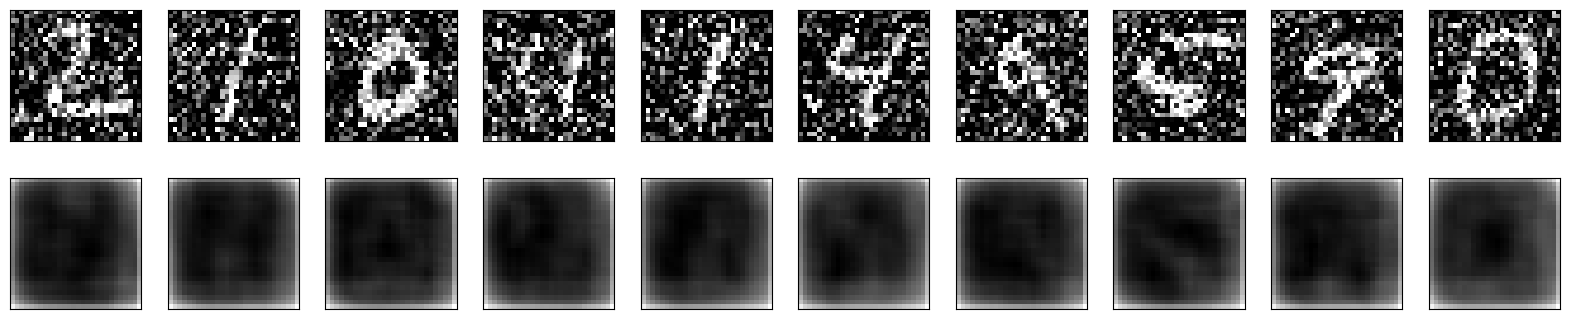

In [6]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import mnist
import matplotlib.pyplot as plt

# Load the MNIST dataset
(train_images, _), (test_images, _) = mnist.load_data()
# Normalize and reshape the images
train_images = train_images.astype('float32') / 255.
test_images = test_images.astype('float32') / 255.
train_images = train_images.reshape((len(train_images), 28, 28, 1))
test_images = test_images.reshape((len(test_images), 28, 28, 1))

# Add random noise to the images
noise_factor = 0.5
train_noisy = train_images + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=train_images.shape)
test_noisy = test_images + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=test_images.shape)
train_noisy = np.clip(train_noisy, 0., 1.)
test_noisy = np.clip(test_noisy, 0., 1.)

# Create the convolutional autoencoder model
input_img = Input(shape=(28, 28, 1))
x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

x = Conv2D(64, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

# Train the autoencoder
autoencoder.fit(train_noisy, train_images, epochs=10, batch_size=128, shuffle=True, validation_data=(test_noisy, test_images))

# Test the autoencoder
decoded_imgs = autoencoder.predict(test_noisy)

# Display the results
n = 10  # How many digits to display
plt.figure(figsize=(20, 4))
for i in range(1, n + 1):
    # Display original images
    ax = plt.subplot(2, n, i)
    plt.imshow(test_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display denoised images
    ax = plt.subplot(2, n, i + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()


Epoch 1/20
469/469 [==============================] - 34s 72ms/step - loss: 0.2312 - val_loss: 0.2285
Epoch 2/20
469/469 [==============================] - 34s 73ms/step - loss: 0.2249 - val_loss: 0.2210
Epoch 3/20
469/469 [==============================] - 34s 72ms/step - loss: 0.2153 - val_loss: 0.2089
Epoch 4/20
469/469 [==============================] - 37s 79ms/step - loss: 0.1995 - val_loss: 0.1897
Epoch 5/20
469/469 [==============================] - 35s 74ms/step - loss: 0.1774 - val_loss: 0.1667
Epoch 6/20
469/469 [==============================] - 34s 73ms/step - loss: 0.1567 - val_loss: 0.1503
Epoch 7/20
469/469 [==============================] - 34s 73ms/step - loss: 0.1440 - val_loss: 0.1414
Epoch 8/20
469/469 [==============================] - 34s 73ms/step - loss: 0.1370 - val_loss: 0.1363
Epoch 9/20
469/469 [==============================] - 34s 73ms/step - loss: 0.1328 - val_loss: 0.1329
Epoch 10/20
469/469 [==============================] - 33s 70ms/step - loss: 0.129

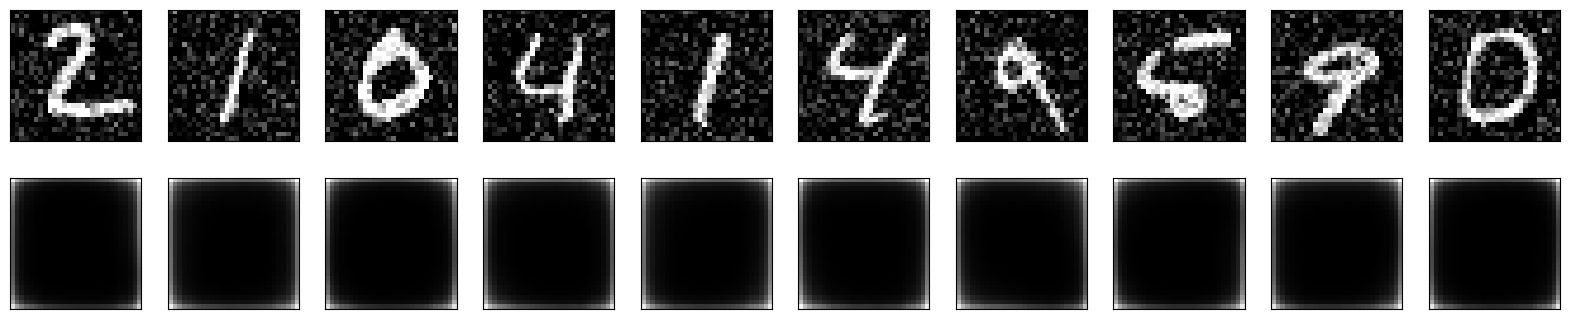

In [7]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import mnist
import matplotlib.pyplot as plt

# Load the MNIST dataset
(train_images, _), (test_images, _) = mnist.load_data()
# Normalize and reshape the images
train_images = train_images.astype('float32') / 255.
test_images = test_images.astype('float32') / 255.
train_images = train_images.reshape((len(train_images), 28, 28, 1))
test_images = test_images.reshape((len(test_images), 28, 28, 1))

# Add random noise to the images (adjust noise factor if needed)
noise_factor = 0.2
train_noisy = train_images + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=train_images.shape)
test_noisy = test_images + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=test_images.shape)
train_noisy = np.clip(train_noisy, 0., 1.)
test_noisy = np.clip(test_noisy, 0., 1.)

# Create the convolutional autoencoder model
input_img = Input(shape=(28, 28, 1))
x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

x = Conv2D(64, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='mean_squared_error')  # Change loss function

# Train the autoencoder
autoencoder.fit(train_noisy, train_images, epochs=20, batch_size=128, shuffle=True, validation_data=(test_noisy, test_images))

# Test the autoencoder
decoded_imgs = autoencoder.predict(test_noisy)

# Display the results
n = 10  # How many digits to display
plt.figure(figsize=(20, 4))
for i in range(1, n + 1):
    # Display original images
    ax = plt.subplot(2, n, i)
    plt.imshow(test_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display denoised images
    ax = plt.subplot(2, n, i + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()


Epoch 1/10
469/469 [==============================] - 32s 68ms/step - loss: 0.2228
Epoch 2/10
469/469 [==============================] - 34s 72ms/step - loss: 0.2078
Epoch 3/10
469/469 [==============================] - 33s 71ms/step - loss: 0.1871
Epoch 4/10
469/469 [==============================] - 34s 74ms/step - loss: 0.1666
Epoch 5/10
469/469 [==============================] - 36s 77ms/step - loss: 0.1522
Epoch 6/10
469/469 [==============================] - 34s 73ms/step - loss: 0.1435
Epoch 7/10
469/469 [==============================] - 34s 72ms/step - loss: 0.1378
Epoch 8/10
469/469 [==============================] - 34s 72ms/step - loss: 0.1336
Epoch 9/10
469/469 [==============================] - 34s 72ms/step - loss: 0.1303
Epoch 10/10
313/313 [==============================] - 3s 9ms/step


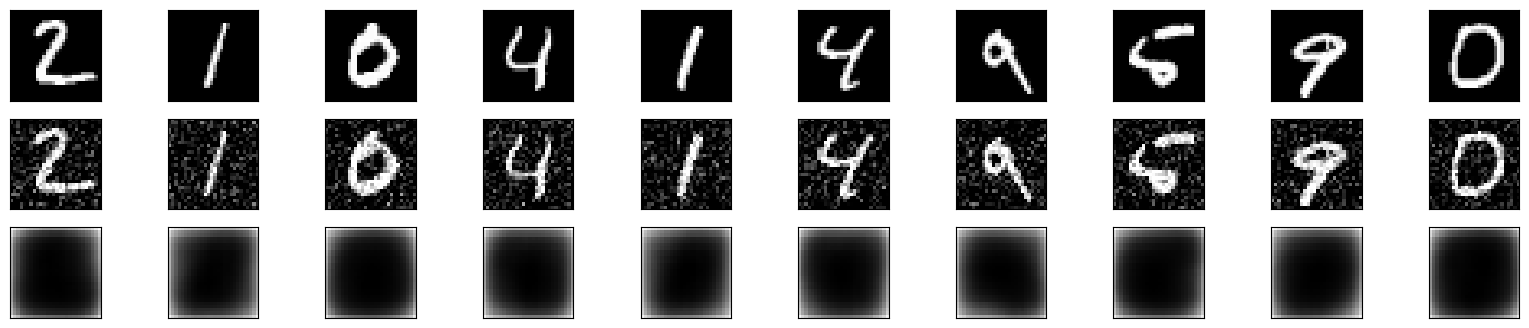

In [9]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import mnist
import matplotlib.pyplot as plt

# Load the MNIST dataset
(train_images, _), (test_images, _) = mnist.load_data()
# Normalize and reshape the images
train_images = train_images.astype('float32') / 255.
test_images = test_images.astype('float32') / 255.
train_images = train_images.reshape((len(train_images), 28, 28, 1))
test_images = test_images.reshape((len(test_images), 28, 28, 1))

# Add random noise to the images (adjust noise factor if needed)
noise_factor = 0.2
train_noisy = train_images + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=train_images.shape)
test_noisy = test_images + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=test_images.shape)
train_noisy = np.clip(train_noisy, 0., 1.)
test_noisy = np.clip(test_noisy, 0., 1.)

# Create the convolutional autoencoder model
input_img = Input(shape=(28, 28, 1))
x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

x = Conv2D(64, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='mean_squared_error')  # Change loss function

# Train the autoencoder for 10 epochs
autoencoder.fit(train_noisy, train_images, epochs=10, batch_size=128, shuffle=True)

# Test the autoencoder
decoded_imgs = autoencoder.predict(test_noisy)

# Display the results
n = 10  # How many digits to display
plt.figure(figsize=(20, 4))
for i in range(1, n + 1):
    # Display original images
    ax = plt.subplot(3, n, i)
    plt.imshow(test_images[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display noisy images
    ax = plt.subplot(3, n, i + n)
    plt.imshow(test_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display denoised images
    ax = plt.subplot(3, n, i + 2*n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()


Epoch 1/10
469/469 [==============================] - 36s 75ms/step - loss: 0.2345
Epoch 2/10
469/469 [==============================] - 35s 76ms/step - loss: 0.2260
Epoch 3/10
469/469 [==============================] - 35s 75ms/step - loss: 0.2160
Epoch 4/10
469/469 [==============================] - 34s 73ms/step - loss: 0.2018
Epoch 5/10
469/469 [==============================] - 34s 72ms/step - loss: 0.1830
Epoch 6/10
469/469 [==============================] - 34s 73ms/step - loss: 0.1646
Epoch 7/10
469/469 [==============================] - 34s 72ms/step - loss: 0.1516
Epoch 8/10
469/469 [==============================] - 34s 72ms/step - loss: 0.1433
Epoch 9/10
469/469 [==============================] - 34s 72ms/step - loss: 0.1377
Epoch 10/10
313/313 [==============================] - 3s 10ms/step


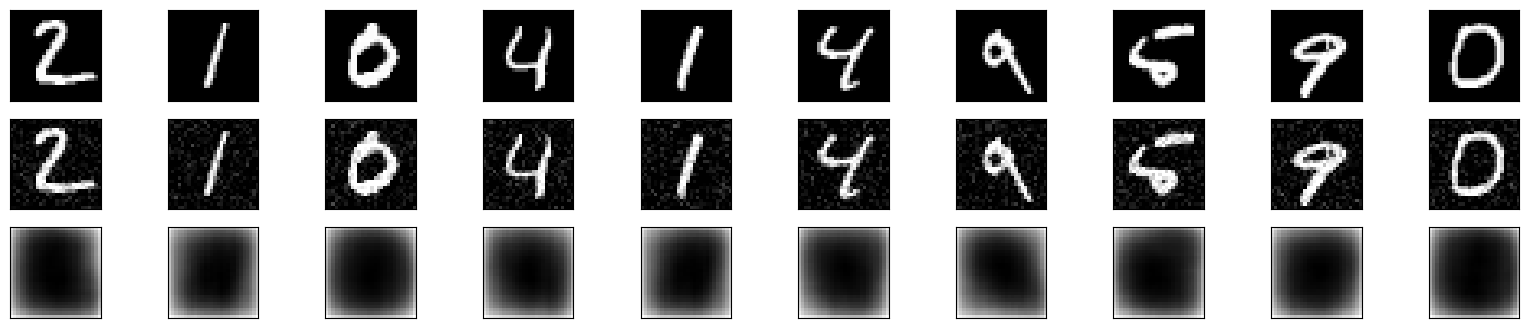

In [10]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, LeakyReLU
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import mnist
import matplotlib.pyplot as plt

# Load the MNIST dataset
(train_images, _), (test_images, _) = mnist.load_data()
# Normalize and reshape the images
train_images = train_images.astype('float32') / 255.
test_images = test_images.astype('float32') / 255.
train_images = train_images.reshape((len(train_images), 28, 28, 1))
test_images = test_images.reshape((len(test_images), 28, 28, 1))

# Add random noise to the images (reduce noise factor if needed)
noise_factor = 0.1
train_noisy = train_images + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=train_images.shape)
test_noisy = test_images + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=test_images.shape)
train_noisy = np.clip(train_noisy, 0., 1.)
test_noisy = np.clip(test_noisy, 0., 1.)

# Create a convolutional autoencoder model with LeakyReLU activation
input_img = Input(shape=(28, 28, 1))
x = Conv2D(32, (3, 3), padding='same')(input_img)
x = LeakyReLU(alpha=0.1)(x)  # LeakyReLU activation
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(64, (3, 3), padding='same')(x)
x = LeakyReLU(alpha=0.1)(x)  # LeakyReLU activation
encoded = MaxPooling2D((2, 2), padding='same')(x)

x = Conv2D(64, (3, 3), padding='same')(encoded)
x = LeakyReLU(alpha=0.1)(x)  # LeakyReLU activation
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), padding='same')(x)
x = LeakyReLU(alpha=0.1)(x)  # LeakyReLU activation
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='mean_squared_error')

# Train the autoencoder for 10 epochs
autoencoder.fit(train_noisy, train_images, epochs=10, batch_size=128, shuffle=True)

# Test the autoencoder
decoded_imgs = autoencoder.predict(test_noisy)

# Display the results
n = 10  # How many digits to display
plt.figure(figsize=(20, 4))
for i in range(1, n + 1):
    # Display original images
    ax = plt.subplot(3, n, i)
    plt.imshow(test_images[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display noisy images
    ax = plt.subplot(3, n, i + n)
    plt.imshow(test_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display denoised images
    ax = plt.subplot(3, n, i + 2 * n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()


Epoch 1/10
469/469 [==============================] - 44s 92ms/step - loss: 0.2327
Epoch 2/10
469/469 [==============================] - 42s 90ms/step - loss: 0.1822
Epoch 3/10
469/469 [==============================] - 47s 100ms/step - loss: 0.1483
Epoch 4/10
469/469 [==============================] - 46s 97ms/step - loss: 0.1232
Epoch 5/10
469/469 [==============================] - 48s 102ms/step - loss: 0.1035
Epoch 6/10
469/469 [==============================] - 49s 104ms/step - loss: 0.0875
Epoch 7/10
469/469 [==============================] - 48s 103ms/step - loss: 0.0746
Epoch 8/10
469/469 [==============================] - 48s 102ms/step - loss: 0.0642
Epoch 9/10
469/469 [==============================] - 47s 100ms/step - loss: 0.0560
Epoch 10/10
313/313 [==============================] - 4s 12ms/step


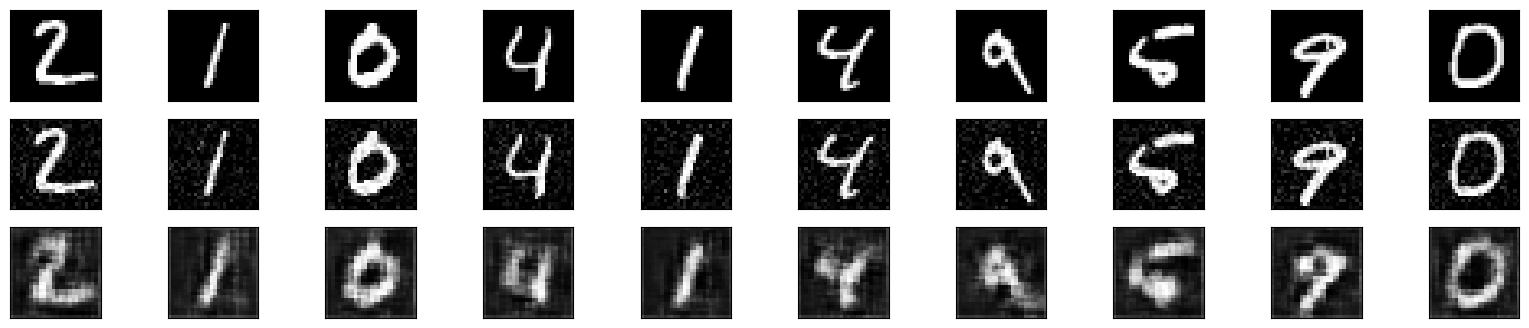

In [11]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, BatchNormalization, Activation
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import mnist
import matplotlib.pyplot as plt

# Load the MNIST dataset
(train_images, _), (test_images, _) = mnist.load_data()
# Normalize and reshape the images
train_images = train_images.astype('float32') / 255.
test_images = test_images.astype('float32') / 255.
train_images = train_images.reshape((len(train_images), 28, 28, 1))
test_images = test_images.reshape((len(test_images), 28, 28, 1))

# Add random noise to the images (reduce noise factor if needed)
noise_factor = 0.1
train_noisy = train_images + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=train_images.shape)
test_noisy = test_images + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=test_images.shape)
train_noisy = np.clip(train_noisy, 0., 1.)
test_noisy = np.clip(test_noisy, 0., 1.)

# Create a deeper convolutional autoencoder model
input_img = Input(shape=(28, 28, 1))
x = Conv2D(32, (3, 3), padding='same')(input_img)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(64, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

x = Conv2D(64, (3, 3), padding='same')(encoded)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='mean_squared_error')

# Train the autoencoder for 10 epochs
autoencoder.fit(train_noisy, train_images, epochs=10, batch_size=128, shuffle=True)

# Test the autoencoder
decoded_imgs = autoencoder.predict(test_noisy)

# Display the results
n = 10  # How many digits to display
plt.figure(figsize=(20, 4))
for i in range(1, n + 1):
    # Display original images
    ax = plt.subplot(3, n, i)
    plt.imshow(test_images[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display noisy images
    ax = plt.subplot(3, n, i + n)
    plt.imshow(test_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display denoised images
    ax = plt.subplot(3, n, i + 2 * n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()


Epoch 1/10
469/469 [==============================] - 90s 191ms/step - loss: 0.1040
Epoch 2/10
469/469 [==============================] - 95s 203ms/step - loss: 0.0676
Epoch 3/10
469/469 [==============================] - 98s 209ms/step - loss: 0.0553
Epoch 4/10
469/469 [==============================] - 95s 203ms/step - loss: 0.0484
Epoch 5/10
469/469 [==============================] - 90s 192ms/step - loss: 0.0439
Epoch 6/10
469/469 [==============================] - 92s 197ms/step - loss: 0.0408
Epoch 7/10
469/469 [==============================] - 98s 208ms/step - loss: 0.0385
Epoch 8/10
469/469 [==============================] - 93s 199ms/step - loss: 0.0367
Epoch 9/10
469/469 [==============================] - 95s 203ms/step - loss: 0.0354
Epoch 10/10
313/313 [==============================] - 7s 21ms/step


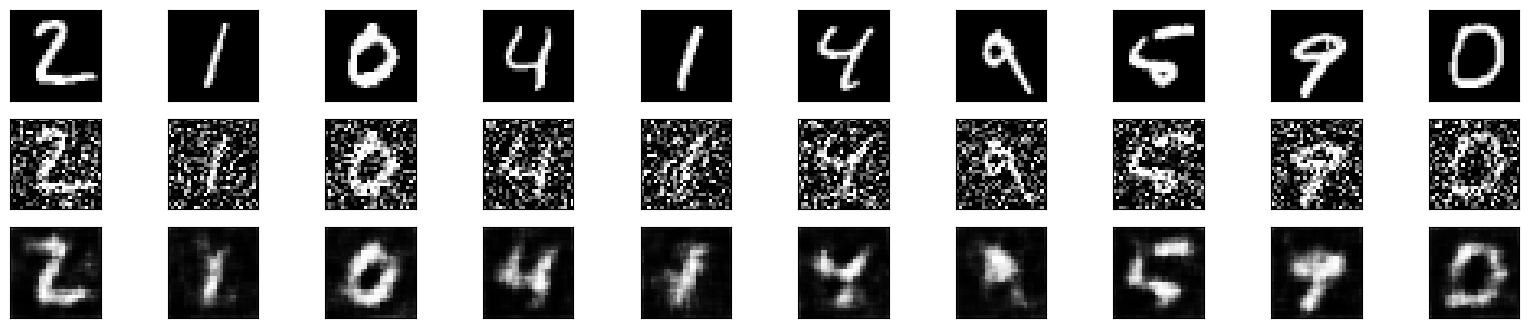

In [12]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, BatchNormalization, Activation
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import mnist
import matplotlib.pyplot as plt

# Load the MNIST dataset
(train_images, _), (test_images, _) = mnist.load_data()
# Normalize and reshape the images
train_images = train_images.astype('float32') / 255.
test_images = test_images.astype('float32') / 255.
train_images = train_images.reshape((len(train_images), 28, 28, 1))
test_images = test_images.reshape((len(test_images), 28, 28, 1))

# Add more noise to the images
noise_factor = 0.5  # Increase the noise factor
train_noisy = train_images + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=train_images.shape)
test_noisy = test_images + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=test_images.shape)
train_noisy = np.clip(train_noisy, 0., 1.)
test_noisy = np.clip(test_noisy, 0., 1.)

# Create a deeper convolutional autoencoder model
input_img = Input(shape=(28, 28, 1))
x = Conv2D(64, (3, 3), padding='same')(input_img)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(128, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

x = Conv2D(128, (3, 3), padding='same')(encoded)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(64, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='mean_squared_error')

# Train the autoencoder for 10 epochs
autoencoder.fit(train_noisy, train_images, epochs=10, batch_size=128, shuffle=True)

# Test the autoencoder
decoded_imgs = autoencoder.predict(test_noisy)

# Display the results
n = 10  # How many digits to display
plt.figure(figsize=(20, 4))
for i in range(1, n + 1):
    # Display original images
    ax = plt.subplot(3, n, i)
    plt.imshow(test_images[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display noisy images
    ax = plt.subplot(3, n, i + n)
    plt.imshow(test_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display denoised images
    ax = plt.subplot(3, n, i + 2 * n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()


In [14]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, BatchNormalization, Activation
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import mnist
import matplotlib.pyplot as plt

# Load the MNIST dataset
(train_images, _), (test_images, _) = mnist.load_data()
# Normalize and reshape the images
train_images = train_images.astype('float32') / 255.
test_images = test_images.astype('float32') / 255.
train_images = train_images.reshape((len(train_images), 28, 28, 1))
test_images = test_images.reshape((len(test_images), 28, 28, 1))

# Add more noise to the images
noise_factor = 0.5  # Increase the noise factor
train_noisy = train_images + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=train_images.shape)
test_noisy = test_images + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=test_images.shape)
train_noisy = np.clip(train_noisy, 0., 1.)
test_noisy = np.clip(test_noisy, 0., 1.)

# Create a deeper and more complex convolutional autoencoder model
input_img = Input(shape=(28, 28, 1))
x = Conv2D(64, (3, 3), padding='same')(input_img)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Conv2D(64, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPooling2D((2, 2))(x)

x = Conv2D(128, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Conv2D(128, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPooling2D((2, 2))(x)

x = Conv2D(256, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Conv2D(256, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)

encoded = x

x = Conv2D(256, (3, 3), padding='same')(encoded)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Conv2D(256, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = UpSampling2D((2, 2))(x)

x = Conv2D(128, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Conv2D(128, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = UpSampling2D((2, 2))(x)

x = Conv2D(64, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Conv2D(64, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = UpSampling2D((2, 2))(x)

decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='mean_squared_error')

# Train the autoencoder for 10 epochs
autoencoder.fit(train_noisy, train_images, epochs=10, batch_size=128, shuffle=True)

# Test the autoencoder
decoded_imgs = autoencoder.predict(test_noisy)

# Display the results
n = 10  # How many digits to display
plt.figure(figsize=(20, 4))
for i in range(1, n + 1):
    # Display original images
    ax = plt.subplot(3, n, i)
    plt.imshow(test_images[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display noisy images
    ax = plt.subplot(3, n, i + n)
    plt.imshow(test_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display denoised images
    ax = plt.subplot(3, n, i + 2 * n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()


Epoch 1/10


ValueError: in user code:

    File "C:\Users\JUDE\anaconda3\Lib\site-packages\keras\src\engine\training.py", line 1377, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\JUDE\anaconda3\Lib\site-packages\keras\src\engine\training.py", line 1360, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\JUDE\anaconda3\Lib\site-packages\keras\src\engine\training.py", line 1349, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\JUDE\anaconda3\Lib\site-packages\keras\src\engine\training.py", line 1127, in train_step
        loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "C:\Users\JUDE\anaconda3\Lib\site-packages\keras\src\engine\training.py", line 1185, in compute_loss
        return self.compiled_loss(
    File "C:\Users\JUDE\anaconda3\Lib\site-packages\keras\src\engine\compile_utils.py", line 277, in __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "C:\Users\JUDE\anaconda3\Lib\site-packages\keras\src\losses.py", line 143, in __call__
        losses = call_fn(y_true, y_pred)
    File "C:\Users\JUDE\anaconda3\Lib\site-packages\keras\src\losses.py", line 270, in call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "C:\Users\JUDE\anaconda3\Lib\site-packages\keras\src\losses.py", line 1706, in mean_squared_error
        return backend.mean(tf.math.squared_difference(y_pred, y_true), axis=-1)

    ValueError: Dimensions must be equal, but are 56 and 28 for '{{node mean_squared_error/SquaredDifference}} = SquaredDifference[T=DT_FLOAT](model_8/conv2d_60/Sigmoid, IteratorGetNext:1)' with input shapes: [?,56,56,1], [?,28,28,1].


In [15]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, BatchNormalization, Activation
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import mnist
import matplotlib.pyplot as plt

# Load the MNIST dataset
(train_images, _), (test_images, _) = mnist.load_data()
# Normalize and reshape the images
train_images = train_images.astype('float32') / 255.
test_images = test_images.astype('float32') / 255.
train_images = train_images.reshape((len(train_images), 28, 28, 1))
test_images = test_images.reshape((len(test_images), 28, 28, 1))

# Add more noise to the images
noise_factor = 0.5  # Increase the noise factor
train_noisy = train_images + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=train_images.shape)
test_noisy = test_images + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=test_images.shape)
train_noisy = np.clip(train_noisy, 0., 1.)
test_noisy = np.clip(test_noisy, 0., 1.)

# Create a deeper and more complex convolutional autoencoder model
input_img = Input(shape=(28, 28, 1))
x = Conv2D(64, (3, 3), padding='same')(input_img)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Conv2D(64, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPooling2D((2, 2))(x)

x = Conv2D(128, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Conv2D(128, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPooling2D((2, 2))(x)

x = Conv2D(256, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Conv2D(256, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)

encoded = x

x = Conv2D(256, (3, 3), padding='same')(encoded)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Conv2D(256, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = UpSampling2D((2, 2))(x)

x = Conv2D(128, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Conv2D(128, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = UpSampling2D((2, 2))(x)

x = Conv2D(64, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Conv2D(64, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = UpSampling2D((2, 2))(x)

decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='mean_squared_error')

# Train the autoencoder for 10 epochs
autoencoder.fit(train_noisy, train_images, epochs=10, batch_size=128, shuffle=True)

# Test the autoencoder
decoded_imgs = autoencoder.predict(test_noisy)

# Display the results
n = 10  # How many digits to display
plt.figure(figsize=(20, 4))
for i in range(1, n + 1):
    # Display original images
    ax = plt.subplot(3, n, i)
    plt.imshow(test_images[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display noisy images
    ax = plt.subplot(3, n, i + n)
    plt.imshow(test_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display denoised images
    ax = plt.subplot(3, n, i + 2 * n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()


Epoch 1/10


ValueError: in user code:

    File "C:\Users\JUDE\anaconda3\Lib\site-packages\keras\src\engine\training.py", line 1377, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\JUDE\anaconda3\Lib\site-packages\keras\src\engine\training.py", line 1360, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\JUDE\anaconda3\Lib\site-packages\keras\src\engine\training.py", line 1349, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\JUDE\anaconda3\Lib\site-packages\keras\src\engine\training.py", line 1127, in train_step
        loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "C:\Users\JUDE\anaconda3\Lib\site-packages\keras\src\engine\training.py", line 1185, in compute_loss
        return self.compiled_loss(
    File "C:\Users\JUDE\anaconda3\Lib\site-packages\keras\src\engine\compile_utils.py", line 277, in __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "C:\Users\JUDE\anaconda3\Lib\site-packages\keras\src\losses.py", line 143, in __call__
        losses = call_fn(y_true, y_pred)
    File "C:\Users\JUDE\anaconda3\Lib\site-packages\keras\src\losses.py", line 270, in call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "C:\Users\JUDE\anaconda3\Lib\site-packages\keras\src\losses.py", line 1706, in mean_squared_error
        return backend.mean(tf.math.squared_difference(y_pred, y_true), axis=-1)

    ValueError: Dimensions must be equal, but are 56 and 28 for '{{node mean_squared_error/SquaredDifference}} = SquaredDifference[T=DT_FLOAT](model_9/conv2d_73/Sigmoid, IteratorGetNext:1)' with input shapes: [?,56,56,1], [?,28,28,1].


Epoch 1/10
469/469 [==============================] - 158s 334ms/step - loss: 0.1732
Epoch 2/10
469/469 [==============================] - 164s 350ms/step - loss: 0.1357
Epoch 3/10
469/469 [==============================] - 163s 348ms/step - loss: 0.1262
Epoch 4/10
469/469 [==============================] - 157s 334ms/step - loss: 0.1199
Epoch 5/10
469/469 [==============================] - 160s 342ms/step - loss: 0.1165
Epoch 6/10
469/469 [==============================] - 150s 319ms/step - loss: 0.1149
Epoch 7/10
469/469 [==============================] - 134s 285ms/step - loss: 0.1141
Epoch 8/10
469/469 [==============================] - 134s 287ms/step - loss: 0.1136
Epoch 9/10
469/469 [==============================] - 136s 289ms/step - loss: 0.1133
Epoch 10/10
313/313 [==============================] - 8s 27ms/step


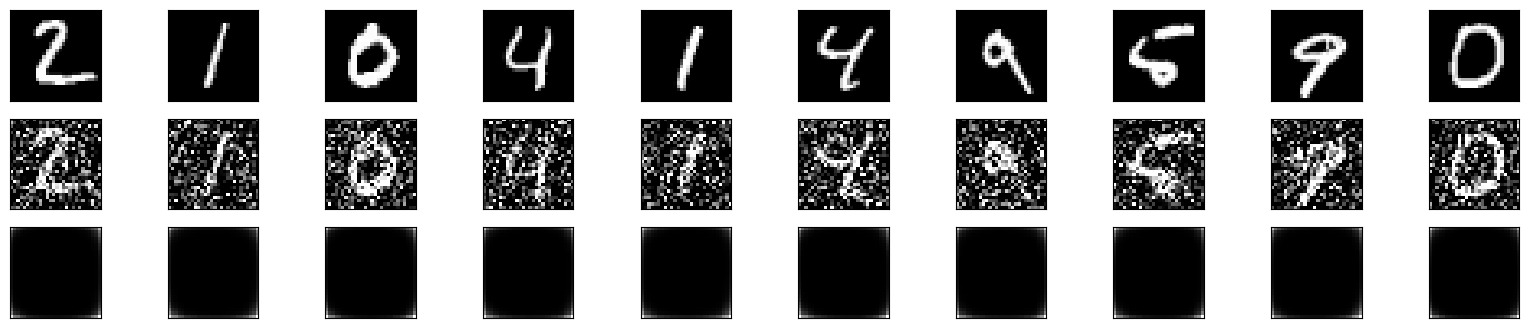

In [16]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import mnist
import matplotlib.pyplot as plt

# Load the MNIST dataset
(train_images, _), (test_images, _) = mnist.load_data()
# Normalize and reshape the images
train_images = train_images.astype('float32') / 255.
test_images = test_images.astype('float32') / 255.
train_images = train_images.reshape((len(train_images), 28, 28, 1))
test_images = test_images.reshape((len(test_images), 28, 28, 1))

# Add more noise to the images
noise_factor = 0.5  # Increase the noise factor
train_noisy = train_images + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=train_images.shape)
test_noisy = test_images + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=test_images.shape)
train_noisy = np.clip(train_noisy, 0., 1.)
test_noisy = np.clip(test_noisy, 0., 1.)

# Create a deeper and more complex convolutional autoencoder model
input_img = Input(shape=(28, 28, 1))
x = Conv2D(64, (3, 3), padding='same')(input_img)
x = Conv2D(64, (3, 3), padding='same')(x)
x = MaxPooling2D((2, 2))(x)

x = Conv2D(128, (3, 3), padding='same')(x)
x = Conv2D(128, (3, 3), padding='same')(x)
x = MaxPooling2D((2, 2))(x)

encoded = x

x = Conv2D(128, (3, 3), padding='same')(encoded)
x = Conv2D(128, (3, 3), padding='same')(x)
x = UpSampling2D((2, 2))(x)

x = Conv2D(64, (3, 3), padding='same')(x)
x = Conv2D(64, (3, 3), padding='same')(x)
x = UpSampling2D((2, 2))(x)

decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='mean_squared_error')

# Train the autoencoder for 10 epochs
autoencoder.fit(train_noisy, train_images, epochs=10, batch_size=128, shuffle=True)

# Test the autoencoder
decoded_imgs = autoencoder.predict(test_noisy)

# Display the results
n = 10  # How many digits to display
plt.figure(figsize=(20, 4))
for i in range(1, n + 1):
    # Display original images
    ax = plt.subplot(3, n, i)
    plt.imshow(test_images[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display noisy images
    ax = plt.subplot(3, n, i + n)
    plt.imshow(test_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display denoised images
    ax = plt.subplot(3, n, i + 2 * n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()


Epoch 1/10
469/469 [==============================] - 82s 174ms/step - loss: 0.2779
Epoch 2/10
469/469 [==============================] - 83s 176ms/step - loss: 0.1932
Epoch 3/10
469/469 [==============================] - 81s 172ms/step - loss: 0.1477
Epoch 4/10
469/469 [==============================] - 81s 173ms/step - loss: 0.1172
Epoch 5/10
469/469 [==============================] - 81s 172ms/step - loss: 0.0939
Epoch 6/10
469/469 [==============================] - 79s 168ms/step - loss: 0.0751
Epoch 7/10
469/469 [==============================] - 78s 167ms/step - loss: 0.0604
Epoch 8/10
469/469 [==============================] - 79s 169ms/step - loss: 0.0497
Epoch 9/10
469/469 [==============================] - 79s 169ms/step - loss: 0.0423
Epoch 10/10
313/313 [==============================] - 6s 18ms/step


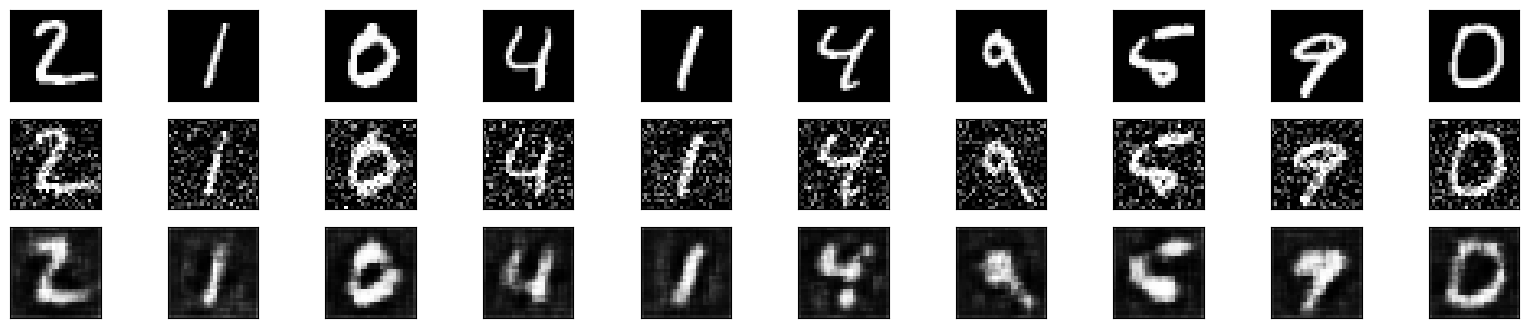

In [17]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, BatchNormalization, Activation
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import mnist
import matplotlib.pyplot as plt

# Load the MNIST dataset
(train_images, _), (test_images, _) = mnist.load_data()
# Normalize and reshape the images
train_images = train_images.astype('float32') / 255.
test_images = test_images.astype('float32') / 255.
train_images = train_images.reshape((len(train_images), 28, 28, 1))
test_images = test_images.reshape((len(test_images), 28, 28, 1))

# Add more noise to the images
noise_factor = 0.3  #adjust the noise factor
train_noisy = train_images + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=train_images.shape)
test_noisy = test_images + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=test_images.shape)
train_noisy = np.clip(train_noisy, 0., 1.)
test_noisy = np.clip(test_noisy, 0., 1.)

# Create a deeper convolutional autoencoder model
input_img = Input(shape=(28, 28, 1))
x = Conv2D(64, (3, 3), padding='same')(input_img)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(128, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

x = Conv2D(128, (3, 3), padding='same')(encoded)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(64, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='mean_squared_error')

# Train the autoencoder for 10 epochs
autoencoder.fit(train_noisy, train_images, epochs=10, batch_size=128, shuffle=True)

# Test the autoencoder
decoded_imgs = autoencoder.predict(test_noisy)

# Display the results
n = 10  # How many digits to display
plt.figure(figsize=(20, 4))
for i in range(1, n + 1):
    # Display original images
    ax = plt.subplot(3, n, i)
    plt.imshow(test_images[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display noisy images
    ax = plt.subplot(3, n, i + n)
    plt.imshow(test_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display denoised images
    ax = plt.subplot(3, n, i + 2 * n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

Epoch 1/10
469/469 [==============================] - 86s 182ms/step - loss: 0.1237
Epoch 2/10
469/469 [==============================] - 126s 268ms/step - loss: 0.0774
Epoch 3/10
469/469 [==============================] - 220s 469ms/step - loss: 0.0586
Epoch 4/10
469/469 [==============================] - 215s 459ms/step - loss: 0.0472
Epoch 5/10
469/469 [==============================] - 215s 458ms/step - loss: 0.0397
Epoch 6/10
469/469 [==============================] - 217s 464ms/step - loss: 0.0345
Epoch 7/10
469/469 [==============================] - 139s 296ms/step - loss: 0.0309
Epoch 8/10
469/469 [==============================] - 81s 173ms/step - loss: 0.0283
Epoch 9/10
469/469 [==============================] - 78s 167ms/step - loss: 0.0262
Epoch 10/10
313/313 [==============================] - 5s 16ms/step


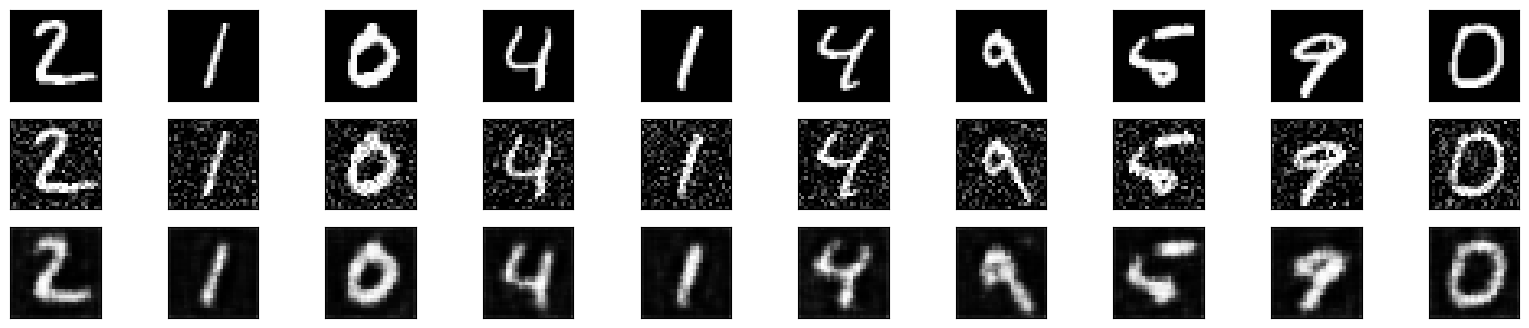

In [18]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, BatchNormalization, Activation
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import mnist
import matplotlib.pyplot as plt

# Load the MNIST dataset
(train_images, _), (test_images, _) = mnist.load_data()
# Normalize and reshape the images
train_images = train_images.astype('float32') / 255.
test_images = test_images.astype('float32') / 255.
train_images = train_images.reshape((len(train_images), 28, 28, 1))
test_images = test_images.reshape((len(test_images), 28, 28, 1))

# Add more noise to the images
noise_factor = 0.225  # Increase the noise factor
train_noisy = train_images + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=train_images.shape)
test_noisy = test_images + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=test_images.shape)
train_noisy = np.clip(train_noisy, 0., 1.)
test_noisy = np.clip(test_noisy, 0., 1.)

# Create a deeper convolutional autoencoder model
input_img = Input(shape=(28, 28, 1))
x = Conv2D(64, (3, 3), padding='same')(input_img)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(128, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

x = Conv2D(128, (3, 3), padding='same')(encoded)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(64, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='mean_squared_error')

# Train the autoencoder for 10 epochs
autoencoder.fit(train_noisy, train_images, epochs=10, batch_size=128, shuffle=True)

# Test the autoencoder
decoded_imgs = autoencoder.predict(test_noisy)

# Display the results
n = 10  # How many digits to display
plt.figure(figsize=(20, 4))
for i in range(1, n + 1):
    # Display original images
    ax = plt.subplot(3, n, i)
    plt.imshow(test_images[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display noisy images
    ax = plt.subplot(3, n, i + n)
    plt.imshow(test_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display denoised images
    ax = plt.subplot(3, n, i + 2 * n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()